In [21]:
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append(str(Path.cwd().parent/'scripts'))
from _helpers import to_datetime

In [22]:
root = Path.cwd().parent / "resources" / "live_data"

prices = []
bmus = []
timestamps = []

for fn in tqdm(os.listdir(root)):

    date, period = fn.split('_')
    date = to_datetime(date, period)

    files = os.listdir(root / fn)
    if 'elexon_bmus.csv' in files and 'price_stats.csv' in files:

        bmu = pd.read_csv(root / fn / 'elexon_bmus.csv', index_col=0)

        bmus.append(bmu[['PN']].rename(columns={'PN': date}))

        price = pd.read_csv(root / fn / 'price_stats.csv', index_col=0)
        prices.append(price.iloc[0,0])
        timestamps.append(date)

bmus = pd.concat(bmus, axis=1).T
prices = pd.Series(prices, timestamps)
ts = prices.index

  0%|          | 0/8865 [00:00<?, ?it/s]

100%|██████████| 8865/8865 [04:43<00:00, 31.32it/s] 


      STAY-2   price
0      436.0  207.22
1      436.0  202.61
2      427.0  195.73
3      427.0  192.31
4      433.0  191.77
...      ...     ...
8186     0.0  -65.02
8187     0.0  -69.58
8188     0.0  -71.33
8189     0.0  -72.97
8190     0.0  -73.24

[8191 rows x 2 columns]


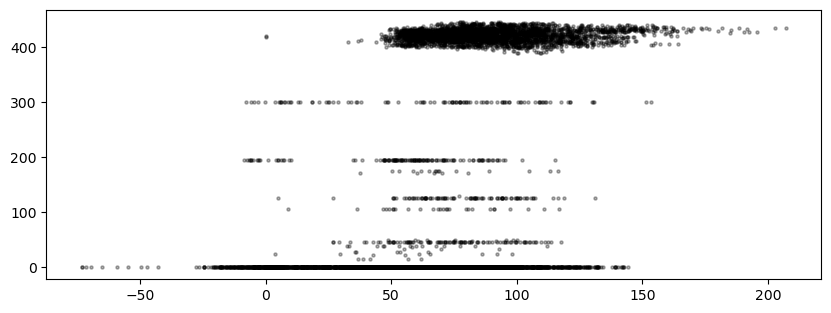

In [60]:
def bmu_analyis(dispatch, prices):

    assert (dispatch.index == prices.index).all()

    df = (
        pd.concat((dispatch, prices), axis=1)
        .rename(columns={0: 'price'})
        .sort_values(by='price', ascending=False)
    )
    df.index = range(len(df))

    fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))

    print(df)
    ax.scatter(df.price.values, df.iloc[:,0], color='k', s=5, alpha=0.3)

    plt.show()


unit = "STAY-2"

bmu_analyis(bmus[unit], prices)


In [246]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import argrelextrema

def get_extremes(dispatch, mode='on', neighbour_filter=10):
    """
    Returns indices of timeseries of dispatch in which a generator is switched on or off.
    Works for high-cost peak-demand meeting generators 
    
    Parameters
    ----------
    dispatch : pd.Series
        Timeseries of dispatch
    mode : str, optional
        'on' or 'off', by default 'on'; on to return times of on-switching else off-switching
    """

    if isinstance(dispatch, pd.DataFrame):
        assert len(dispatch.columns) == 0, 'unclear how to handle multiple columns in dispatch dataframe'
        dispatch = dispatch.iloc[:,0]

    if dispatch.max() > 1.:
        dispatch = pd.Series(
            MinMaxScaler().fit_transform(dispatch.values.reshape(-1, 1)).flatten(),
            index=dispatch.index
        )
    
    rounded = dispatch.fillna(0.).round()

    deriv_window_size = 10
    deriv = (
        rounded
        .rolling(deriv_window_size, center=True)
        .apply(lambda x: x[deriv_window_size//2:].mean() - x[:deriv_window_size//2].mean())
    )

    if mode == 'on':
        extreme_func = np.less_equal
    elif mode == 'off':
        extreme_func = np.greater_equal
    else:
        raise ValueError('mode must be either "on" or "off"')

    extremes = np.array(argrelextrema(deriv.values, extreme_func, order=5)[0])

    extremes = extremes[deriv.iloc[extremes] != 0]

    # minor cleanup; remove neighbouring values
    mask = np.abs(np.roll(extremes, 1) - extremes) < neighbour_filter
    mask = mask + np.roll(mask, -1)

    extremes = extremes[~mask]
    
    return extremes


def get_bmu_price_distribution(dispatch, prices):

    full_index = pd.date_range(prices.index[0], prices.index[-1], freq='30T')

    prices = prices.copy().reindex(full_index).interpolate()
    dispatch = dispatch.copy().reindex(full_index).interpolate()

    switchons = get_extremes(dispatch, mode='on')
    switchoffs = get_extremes(dispatch, mode='off')

    switchons = pd.Index([dispatch.index[n] for n in switchons])
    switchoffs = pd.Index([dispatch.index[n] for n in switchoffs])

    avg_prices = list()

    for on in switchons:

        try:
            off = switchoffs[switchoffs > on][0]
        except IndexError:
            continue

        avg_prices.append(prices.loc[on:off].mean())
    
    return avg_prices


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


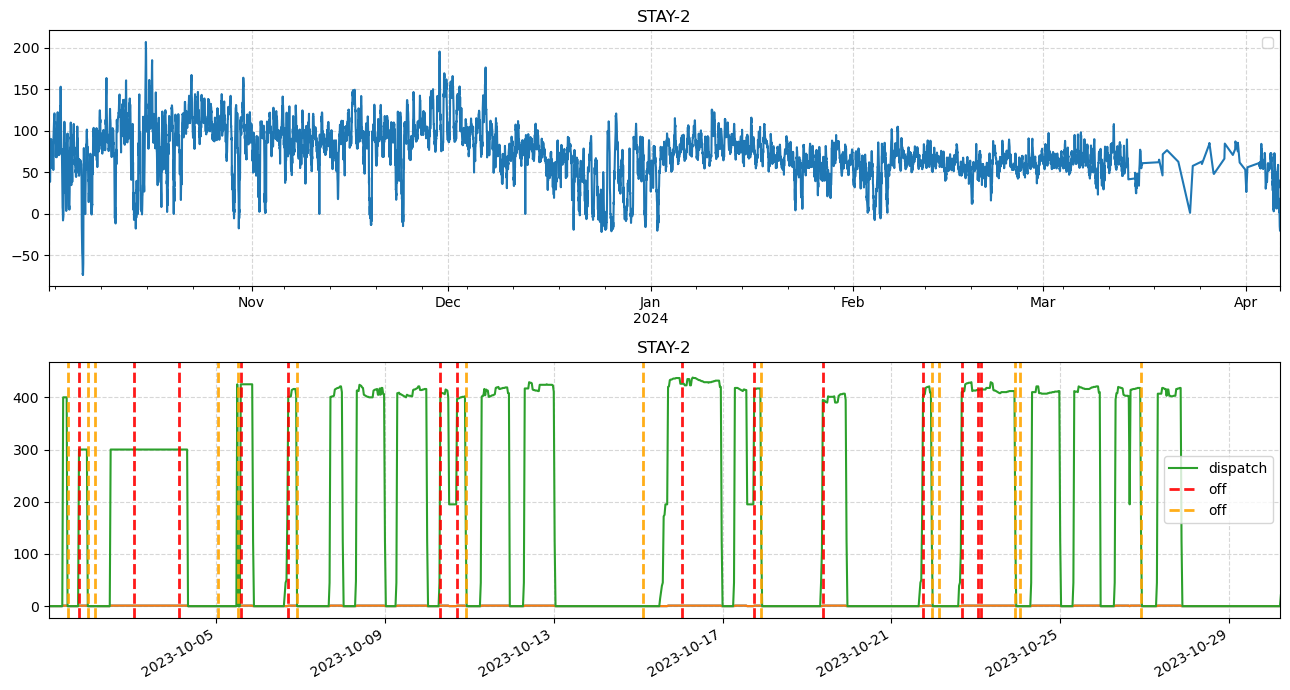

In [233]:
fig, axs = plt.subplots(2, 1, figsize=(13, 7))
prices.plot(ax=axs[0])
p = bmus[unit]

full_index = pd.date_range(prices.index[0], prices.index[-1], freq='30T')

switchons = get_extremes(p, mode='on')
switchoffs = get_extremes(p, mode='off')

p.plot(ax=axs[1], label='dispatch')


for i, n in enumerate(switchoffs):

    if i == 0:
        label = 'off'
    else:
        label = None
    axs[1].axvline(p.index[n], color='r', linestyle='--', alpha=0.9, label=label, linewidth=2)

for i, n in enumerate(switchons):

    if i == 0:
        label = 'off'
    else:
        label = None

    axs[1].axvline(p.index[n], color='orange', linestyle='--', alpha=0.9, label=label, linewidth=2)

switchons = pd.Index([p.index[n] for n in switchons])
switchoffs = pd.Index([p.index[n] for n in switchoffs])


for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()
    ax.set_title(unit)

ax.set_xlim(full_index[0], full_index[1400])
plt.tight_layout()
plt.show()

In [229]:
diffs = []
avg_prices = list()

for on in switchons:

    try:
        off = switchoffs[switchoffs > on][0]
    except IndexError:
        continue

    avg_prices.append(prices.loc[on:off].mean())

'\navg_price_frames = [\n    (on, switchoffs[on:][0]) for on in switchons if len(switchoffs[on:]) > 0\n]\navg_prices = [\n    prices.loc[on:off].mean() for on, off in avg_price_frames\n]\n'

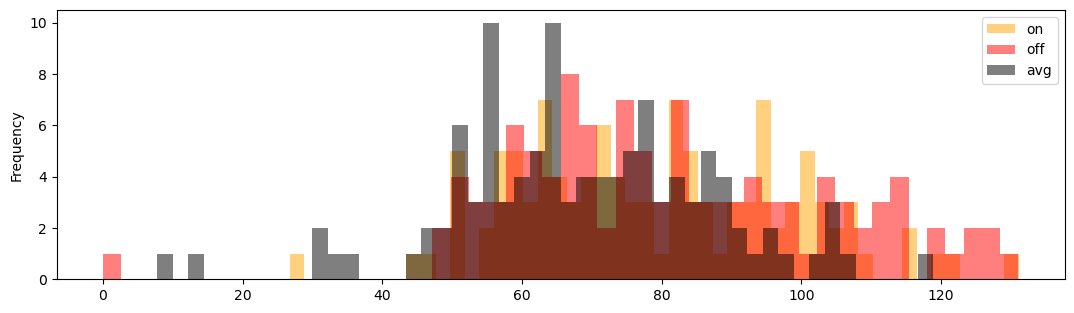

In [231]:
fig, ax = plt.subplots(1, 1, figsize=(13, 3.5))

prices.loc[switchons].plot.hist(ax=ax, bins=50, alpha=0.5, color='orange', label='on')
prices.loc[switchoffs].plot.hist(ax=ax, bins=50, alpha=0.5, color='r', label='off')
pd.Series(avg_prices).plot.hist(ax=ax, bins=50, alpha=0.5, color='k', label='avg')

ax.legend()
plt.show()

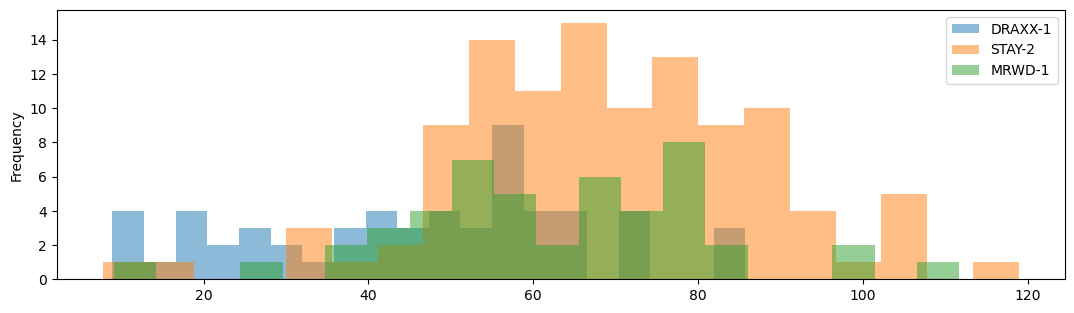

In [247]:
fig, ax = plt.subplots(1, 1, figsize=(13, 3.5))


results = {}
for unit in ["DRAXX-1", "STAY-2", "MRWD-1"]:

    results[unit] = pd.Series(get_bmu_price_distribution(bmus[unit], prices))
    results[unit].plot.hist(ax=ax, bins=20, alpha=0.5, label=unit)

ax.legend()
plt.show()

In [245]:
results['DRAXX-1']

0     77.459286
1     91.025849
2     92.023333
3     64.652963
4     62.090000
        ...    
58    63.555823
59    64.530667
60    63.026000
61    65.384182
62    67.425778
Length: 63, dtype: float64

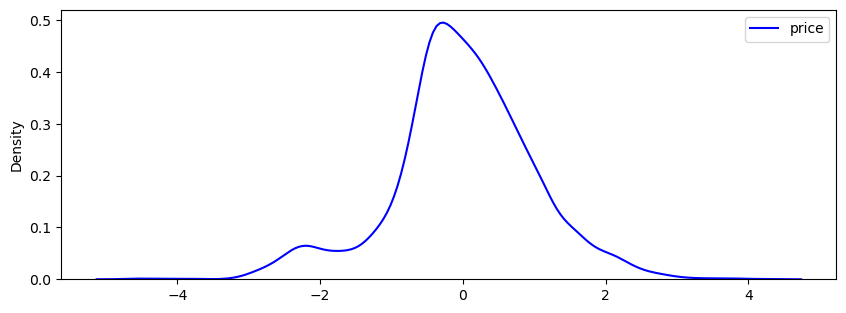

In [87]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10, 3.5))

sns.kdeplot(StandardScaler().fit_transform(df[['price']]).flatten(), ax=ax, color='blue', label='price')

ax.legend()
plt.show()

In [79]:
df

,STAY-2,price
2023-10-15 20:00:00,436.0,207.22
2023-10-15 20:30:00,436.0,202.61
2023-11-29 17:30:00,427.0,195.73
2023-11-29 18:00:00,427.0,192.31
2023-11-29 18:30:00,433.0,191.77
...,...,...
2023-10-06 06:00:00,0.0,-65.02
2023-10-06 04:00:00,0.0,-69.58
2023-10-06 05:00:00,0.0,-71.33
2023-10-06 04:30:00,0.0,-72.97


In [235]:
bmus.sum().sort_values(ascending=False).head(20)

ISG-NDPL1    7076540.0
SIZB-1       4918697.0
SIZB-2       4893932.0
HUMR-1       4473836.0
HEYM28       4423082.0
HEYM27       4328471.0
DRAXX-2      4166520.0
TORN-2       4052568.0
TORN-1       4046135.0
DRAXX-3      3902254.0
MRWD-1       3893622.0
DRAXX-1      3459310.0
DIDCB5       3143481.0
SPLN-1       3116117.0
KEAD-2       2738880.0
IFG-VSAL1    2698133.0
PEHE-1       2593068.0
DRAXX-4      2545410.0
HRTL-1       2512158.0
LAGA-1       2490456.0
dtype: float64